# NL COVID 19 data exploration

- data from https://data.rivm.nl/covid-19/
- taken 2020-09-17

## Notes

- Given that daily reported numbers are in small quantities
(i.e. <100), changes represented in % changes
can be highly sensitive.
E.g. Changing from 1 to 5 is a 500% change.
- But % change is the only way to
compare change in qty across different slices
of data.
- So take those figures with a pinch of salt.
- That being said, we are looking for anomalies,
so a sufficiently large % change would signal
an abnormally large change.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import typing

plt.rcParams["figure.figsize"] = (20,15)
_FONTSIZE=20

# Initial data management
_DATADIR="_data"
_DATA_CUMUL="COVID-19_aantallen_gemeente_cumulatief-2020-09-17.csv"
cumul = pd.read_csv(os.path.join(_DATADIR, _DATA_CUMUL), delimiter=";")
cumul["Date_of_report"] = pd.to_datetime(cumul["Date_of_report"]) # set dtype of "Date_of_report" to pd.DatetimeTZDtype
cumul["Date_of_report"] = cumul["Date_of_report"].dt.normalize() # get date portion of datetime only
cumul.sort_values(by="Date_of_report",ascending=True,inplace=True)

 # Get only cases from Amsterdam:
cumul_ams = cumul[cumul["Municipality_name"].isin(["Amsterdam"])]

# compare day on day increments/deltas
def get_daily_delta(df: pd.DataFrame, col: str) -> typing.List[int]:
    """
    Returns list containing day to day changes in reported cases
    """
    daily_delta_column = []
    reported = df[col]
    for i in range(0,len(reported)):
        if i == 0:
            daily_delta_column.append(0)
            continue # skip this index
        daily_delta_column.append(
            reported.iloc[i]-reported.iloc[i-1]
        )

    return daily_delta_column

cumul_ams.insert(len(cumul_ams.columns), "Day",cumul_ams["Date_of_report"].dt.day_name()) # create new column for day of week
cumul_ams["Day"].astype("str")
cumul_ams.insert(len(cumul_ams.columns), "Week", cumul_ams["Date_of_report"].dt.week) # create new column for week number
cumul_ams.insert(len(cumul_ams.columns),"Daily_delta",get_daily_delta(cumul_ams, "Total_reported")) # add daily delta of total reported to df
cumul_ams.insert(len(cumul_ams.columns),"Deceased_delta",get_daily_delta(cumul_ams, "Deceased")) # add daily delta of total deceased to df
cumul_ams.insert(len(cumul_ams.columns),"Hospital_delta",get_daily_delta(cumul_ams, "Hospital_admission")) # add daily delta of total hospitalized to df

### Get only the data we want from dataframe

In [2]:
# create working df with: date, cumulative day of week, week number, reports
cumuldf = cumul_ams[
    ["Date_of_report","Day","Week","Daily_delta", "Total_reported", "Deceased", "Deceased_delta", "Hospital_admission", "Hospital_delta"]
]
cumuldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189 entries, 109 to 69105
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_of_report      189 non-null    datetime64[ns]
 1   Day                 189 non-null    object        
 2   Week                189 non-null    int64         
 3   Daily_delta         189 non-null    int64         
 4   Total_reported      189 non-null    int64         
 5   Deceased            189 non-null    int64         
 6   Deceased_delta      189 non-null    int64         
 7   Hospital_admission  189 non-null    int64         
 8   Hospital_delta      189 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 14.8+ KB


### Data from last 10 days

In [3]:
cumuldf.tail(10)

,Date_of_report,Day,Week,Daily_delta,Total_reported,Deceased,Deceased_delta,Hospital_admission,Hospital_delta
65802,2020-09-08,Tuesday,37,190,7009,292,0,676,1
66169,2020-09-09,Wednesday,37,132,7141,292,0,675,-1
66536,2020-09-10,Thursday,37,126,7267,292,0,683,8
66903,2020-09-11,Friday,37,186,7453,293,1,686,3
67270,2020-09-12,Saturday,37,166,7619,293,0,686,0
67637,2020-09-13,Sunday,37,193,7812,294,1,692,6
68004,2020-09-14,Monday,38,199,8011,294,0,694,2
68371,2020-09-15,Tuesday,38,249,8260,295,1,696,2
68738,2020-09-16,Wednesday,38,240,8500,295,0,699,3
69105,2020-09-17,Thursday,38,247,8747,295,0,701,2


### Top 10 days (reported cases)

In [4]:
sorted_df = cumuldf[["Date_of_report","Week","Daily_delta","Total_reported","Hospital_delta"]].sort_values(by="Daily_delta",ascending=False)
sorted_df.head(10)

,Date_of_report,Week,Daily_delta,Total_reported,Hospital_delta
68371,2020-09-15,38,249,8260,2
69105,2020-09-17,38,247,8747,2
68738,2020-09-16,38,240,8500,3
68004,2020-09-14,38,199,8011,2
67637,2020-09-13,37,193,7812,6
65802,2020-09-08,37,190,7009,1
66903,2020-09-11,37,186,7453,3
55159,2020-08-10,33,177,4089,3
67270,2020-09-12,37,166,7619,0
53691,2020-08-06,32,147,3659,-1


In [5]:
def get_week_start_end(df:pd.DataFrame, week_number:int)->typing.Tuple[str,str]:
    """
    Returns a tuple of (week_start, week_end),
    that are two strings:
    - week_start is the start date of a week (i.e. dd/mm on that monday)
    - week_end is the end date of a week (i.e. dd/mm on that sunday)
    """
    df_week = df["Week"]
    # this_week = df[df_week == df_week.max()-week_number]
    this_week = df[df_week == week_number]
    week_start = this_week.iloc[0]["Date_of_report"]
    week_start_d_m = f"{week_start.day}/{week_start.month}"
    week_end = this_week.iloc[-1]["Date_of_report"]
    week_end_d_m = f"{week_end.day}/{week_end.month}"
    return week_start_d_m, week_end_d_m


def plot_daily_delta_for_last_n_weeks(df:pd.DataFrame, n:int=3):
    """
    Plots n number of weeks
    worth of daily deltas in one line chart
    """
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.xlabel("Day of week", fontsize=_FONTSIZE)
    plt.yticks(np.arange(0, df["Daily_delta"].max(), step=5), fontsize=_FONTSIZE)
    plt.ylabel("Daily change", fontsize=_FONTSIZE)

    for week in range(0,n):
        this_week_number = df["Week"].max() - week
        this_week = df[df["Week"] == this_week_number]
        last_week = df[df["Week"] == this_week_number-1]

        x_range = ["(Sunday before)"]+this_week["Day"].to_list()
        including_last_sunday = [last_week["Daily_delta"].to_list()[-1]]+this_week["Daily_delta"].to_list()
        week_start_d_m, week_end_d_m = get_week_start_end(df,this_week_number)

        plt.plot(x_range,including_last_sunday,label=f"{week_start_d_m} – {week_end_d_m}")
    plt.legend(fontsize=_FONTSIZE)

### Plot day to day change in reported cases, by week

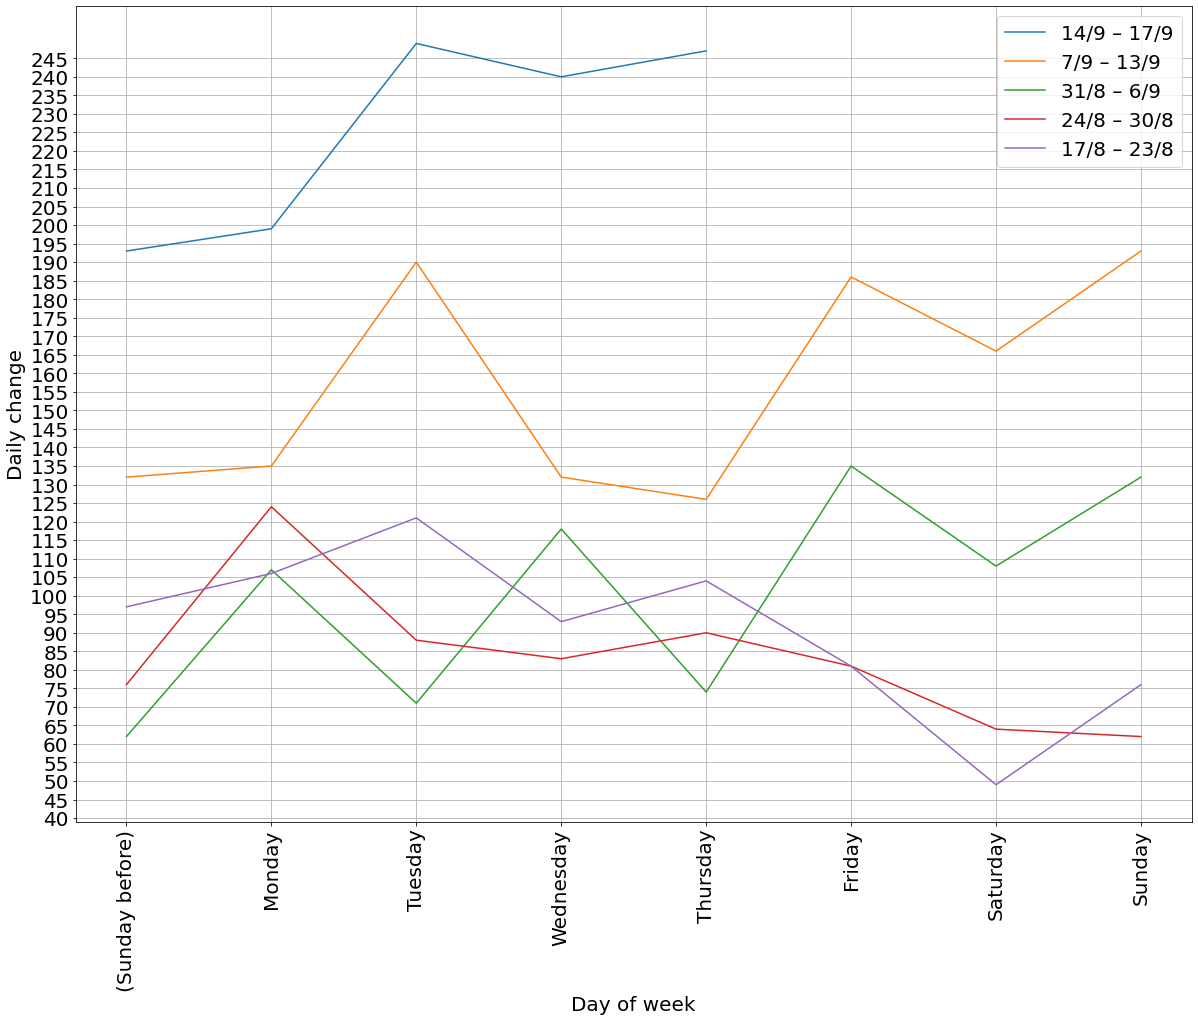

,Date_of_report,Week,Daily_delta,Total_reported
66903,2020-09-11,37,186,7453
67270,2020-09-12,37,166,7619
67637,2020-09-13,37,193,7812
68004,2020-09-14,38,199,8011
68371,2020-09-15,38,249,8260
68738,2020-09-16,38,240,8500
69105,2020-09-17,38,247,8747


In [6]:
plot_daily_delta_for_last_n_weeks(cumuldf, n=5)
plt.show()

cumuldf[["Date_of_report","Week","Daily_delta","Total_reported"]].tail(7)

In [7]:
def plot_weekly_delta_for_last_n_weeks(df:pd.DataFrame, n:int) -> typing.Dict[str,int]:
    """
    Returns a dict containing weekly delta for the last n weeks,
    like: {"Week n": int,"Week n-1": int, ...}
    """

    weekly_delta = {}
    for week in range(0,n):
        if df["Week"].max() < week:
            print(f"Week no. {df['Week'].max() - week} does not exist.")
            continue

        this_week_num = df["Week"].max() - week
        week_delta = df[df["Week"] == this_week_num]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_delta[f"Week {this_week_num}"] = 0
            continue
        else:
            weekly_delta[f"Week {this_week_num}"] = week_delta
            continue
    return weekly_delta



### Plot week-on-week change in reported cases

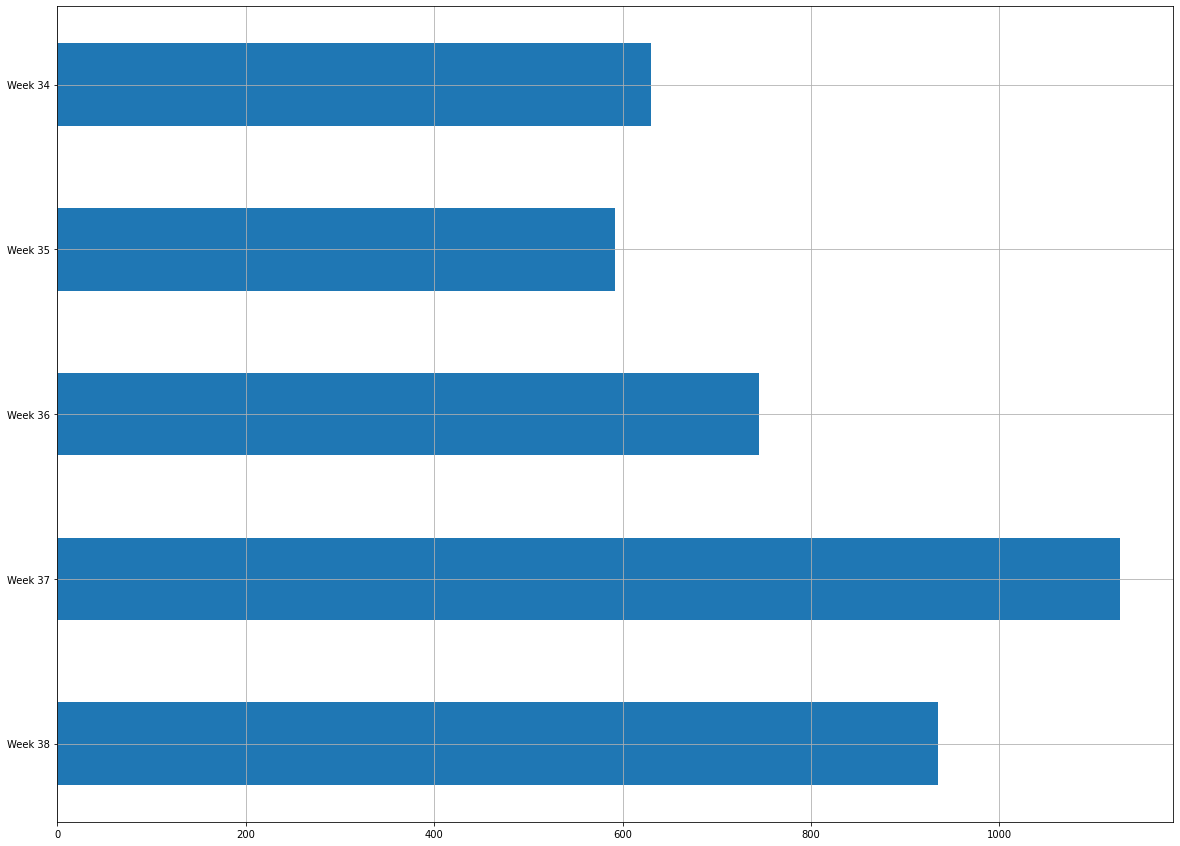

{'Week 34': 630,
 'Week 35': 592,
 'Week 36': 745,
 'Week 37': 1128,
 'Week 38': 935}


In [8]:
weekly_delta = plot_weekly_delta_for_last_n_weeks(cumuldf, 5)
plt.grid(True)
plt.barh(
    list(weekly_delta.keys()),
    width=np.array(list(weekly_delta.values())),
    height=0.5
)
plt.show()
pprint(weekly_delta)

In [9]:
def weekly_percentage_incr_for_last_n_weeks(df:pd.DataFrame, n:int) -> typing.Dict[str,float]:
    weekly_percent_delta = {}
    for week in range(0,n):
        if df["Week"].max() < week:
            print(
                f"Week no. {df['Week'].max() - week} does not exist."
            )
            continue

        this_week_num = df["Week"].max() - week
        week_delta = df[
            df["Week"] == this_week_num
        ]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_percent_delta[
                f"Week {this_week_num}"] = 0
            continue
        else:
            last_week_delta = df[
                df["Week"] == (this_week_num-1)
            ]["Daily_delta"].sum()

            weekly_percent_delta[f"Week {this_week_num}"] = \
                ((week_delta-last_week_delta)/last_week_delta)*100

    return weekly_percent_delta

### Plot week-on-week percentage change in reported cases

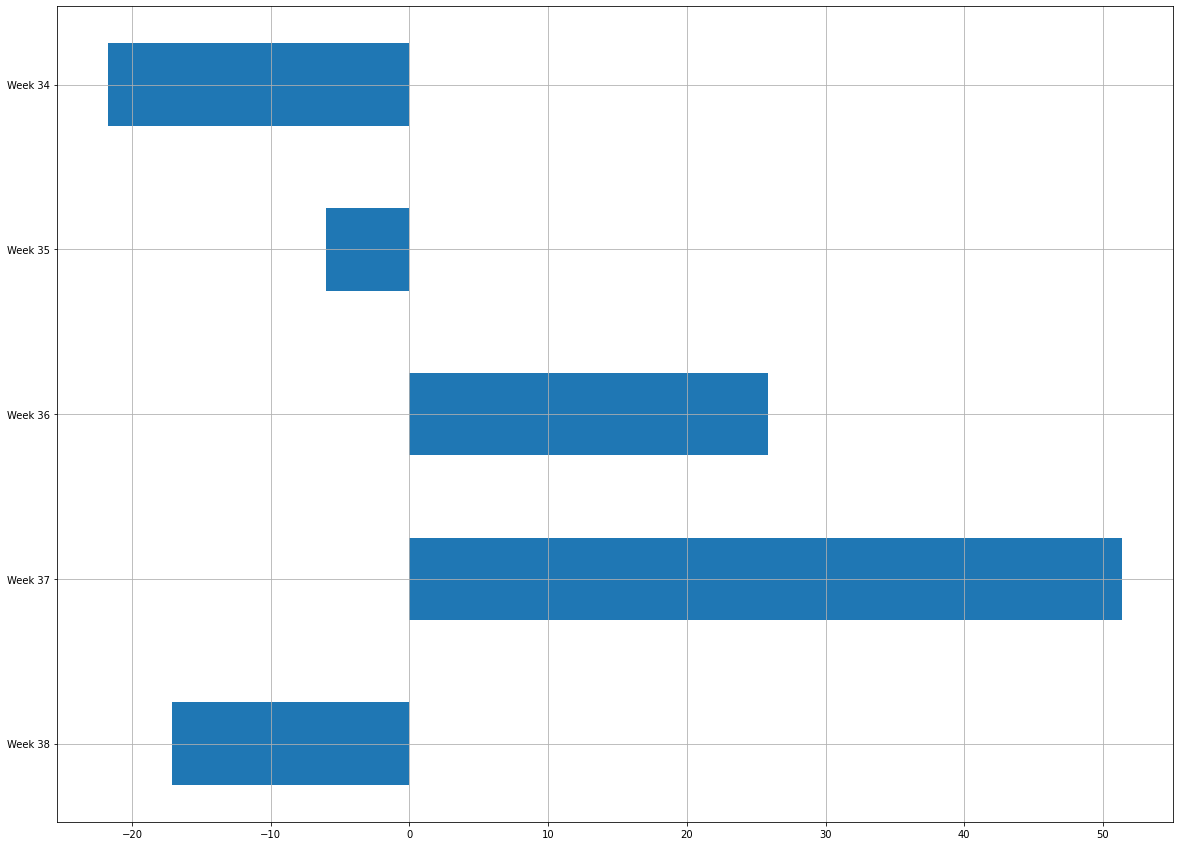

{'Week 34': -21.73913043478261,
 'Week 35': -6.031746031746032,
 'Week 36': 25.844594594594593,
 'Week 37': 51.40939597315436,
 'Week 38': -17.109929078014186}


In [10]:
plt.grid(True)
weekly_percent_delta = \
    weekly_percentage_incr_for_last_n_weeks(cumuldf,5)
plt.barh(
    list(weekly_percent_delta.keys()),
    width=np.array(list(weekly_percent_delta.values())),
    height=0.5)
plt.show()
pprint(weekly_percent_delta)

In [11]:
# Helper function to plot last n days cumulative reported cases

def plot_cumul_reported_last_n_days(df:pd.DataFrame,n:int=3, col:str="Total_reported") -> None:
    plot_this = df.tail(n)
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.yticks(plot_this[col], fontsize=_FONTSIZE)
    plt.plot_date(
        plot_this["Date_of_report"].loc[-n:,],
        plot_this[col],
        xdate=True
    )
    plt.show()
    pprint(df[["Date_of_report", col]].tail(n))

### Cumulative reported cases for the last 7 days

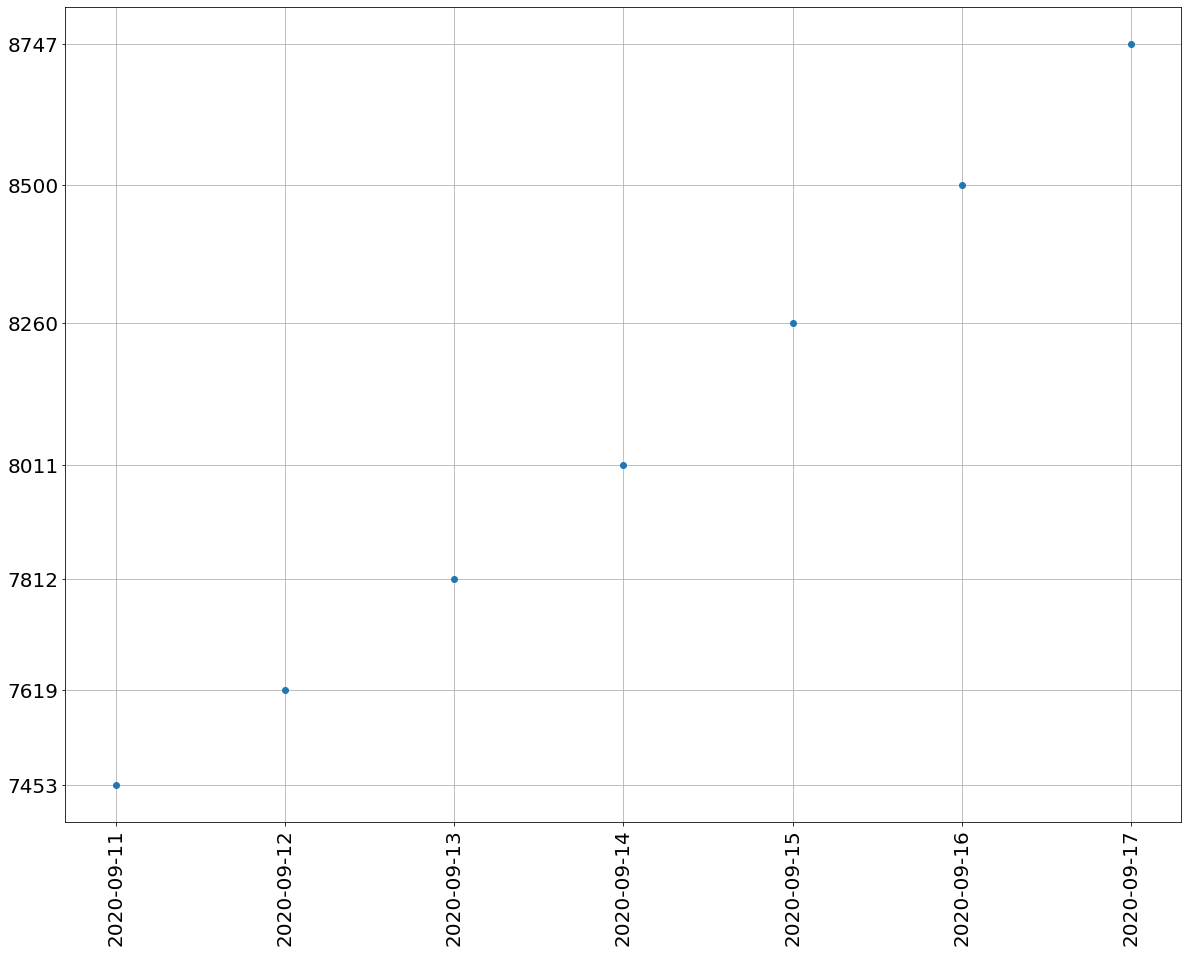

      Date_of_report  Total_reported
66903     2020-09-11            7453
67270     2020-09-12            7619
67637     2020-09-13            7812
68004     2020-09-14            8011
68371     2020-09-15            8260
68738     2020-09-16            8500
69105     2020-09-17            8747


In [12]:
plot_cumul_reported_last_n_days(cumuldf, 7, "Total_reported")

### Cumulative reported cases for the last 14 days

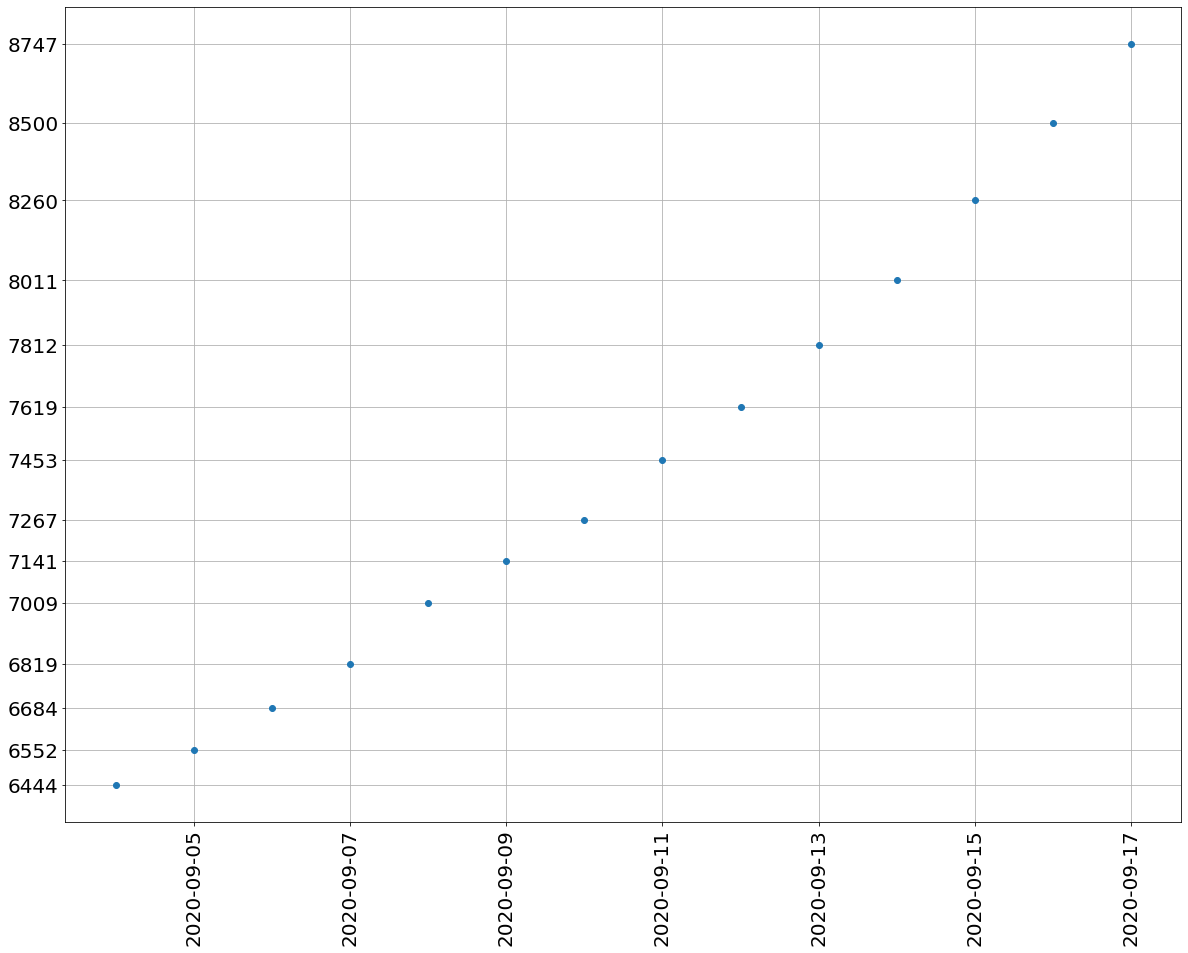

      Date_of_report  Total_reported
64334     2020-09-04            6444
64701     2020-09-05            6552
65068     2020-09-06            6684
65435     2020-09-07            6819
65802     2020-09-08            7009
66169     2020-09-09            7141
66536     2020-09-10            7267
66903     2020-09-11            7453
67270     2020-09-12            7619
67637     2020-09-13            7812
68004     2020-09-14            8011
68371     2020-09-15            8260
68738     2020-09-16            8500
69105     2020-09-17            8747


In [13]:
plot_cumul_reported_last_n_days(cumuldf, 14, "Total_reported")

### Cumulative reported cases for the last 30 days

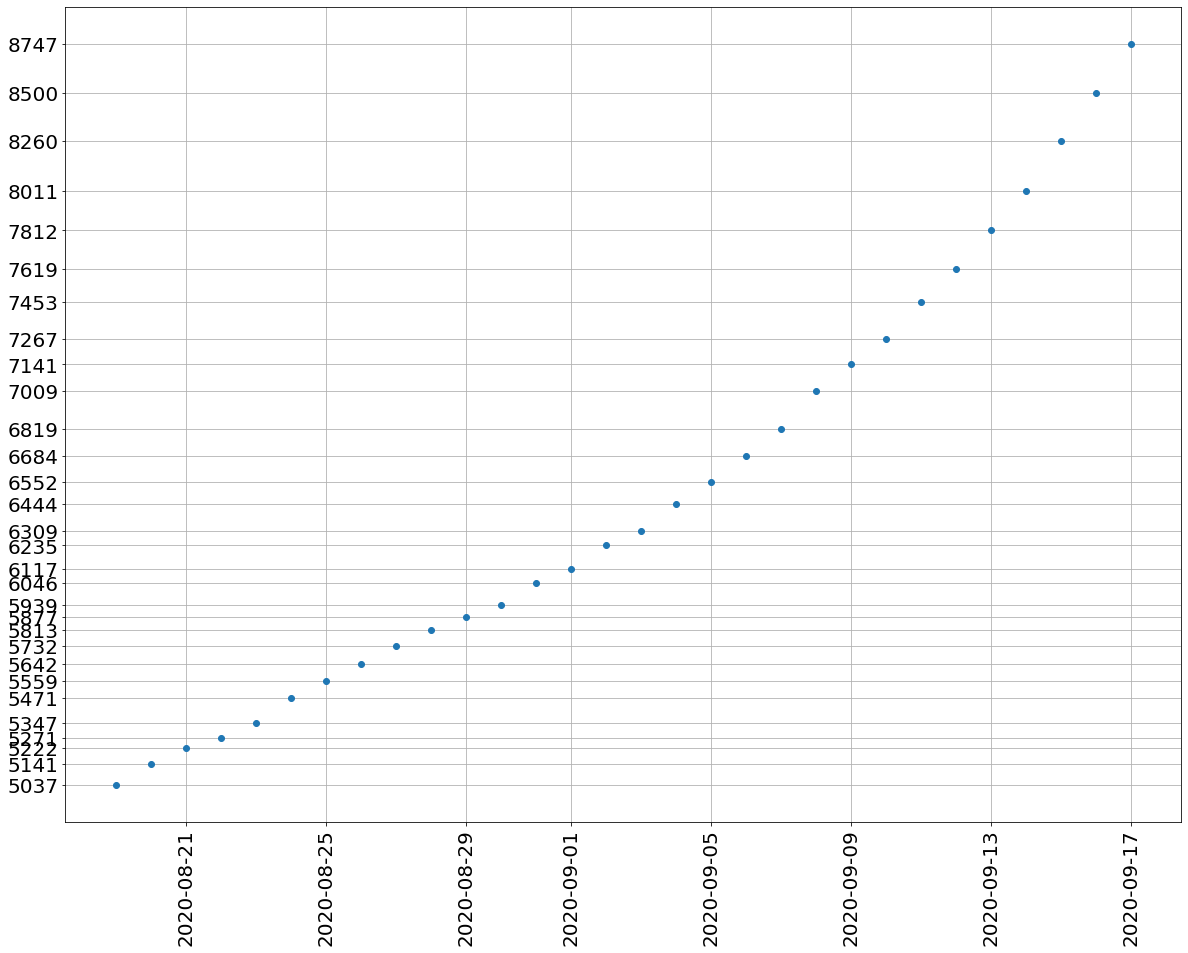

      Date_of_report  Total_reported
58462     2020-08-19            5037
58829     2020-08-20            5141
59196     2020-08-21            5222
59563     2020-08-22            5271
59930     2020-08-23            5347
60297     2020-08-24            5471
60664     2020-08-25            5559
61031     2020-08-26            5642
61398     2020-08-27            5732
61765     2020-08-28            5813
62132     2020-08-29            5877
62499     2020-08-30            5939
62866     2020-08-31            6046
63233     2020-09-01            6117
63600     2020-09-02            6235
63967     2020-09-03            6309
64334     2020-09-04            6444
64701     2020-09-05            6552
65068     2020-09-06            6684
65435     2020-09-07            6819
65802     2020-09-08            7009
66169     2020-09-09            7141
66536     2020-09-10            7267
66903     2020-09-11            7453
67270     2020-09-12            7619
67637     2020-09-13            7812
6

In [14]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Total_reported")

### Cumulative reported cases since beginning

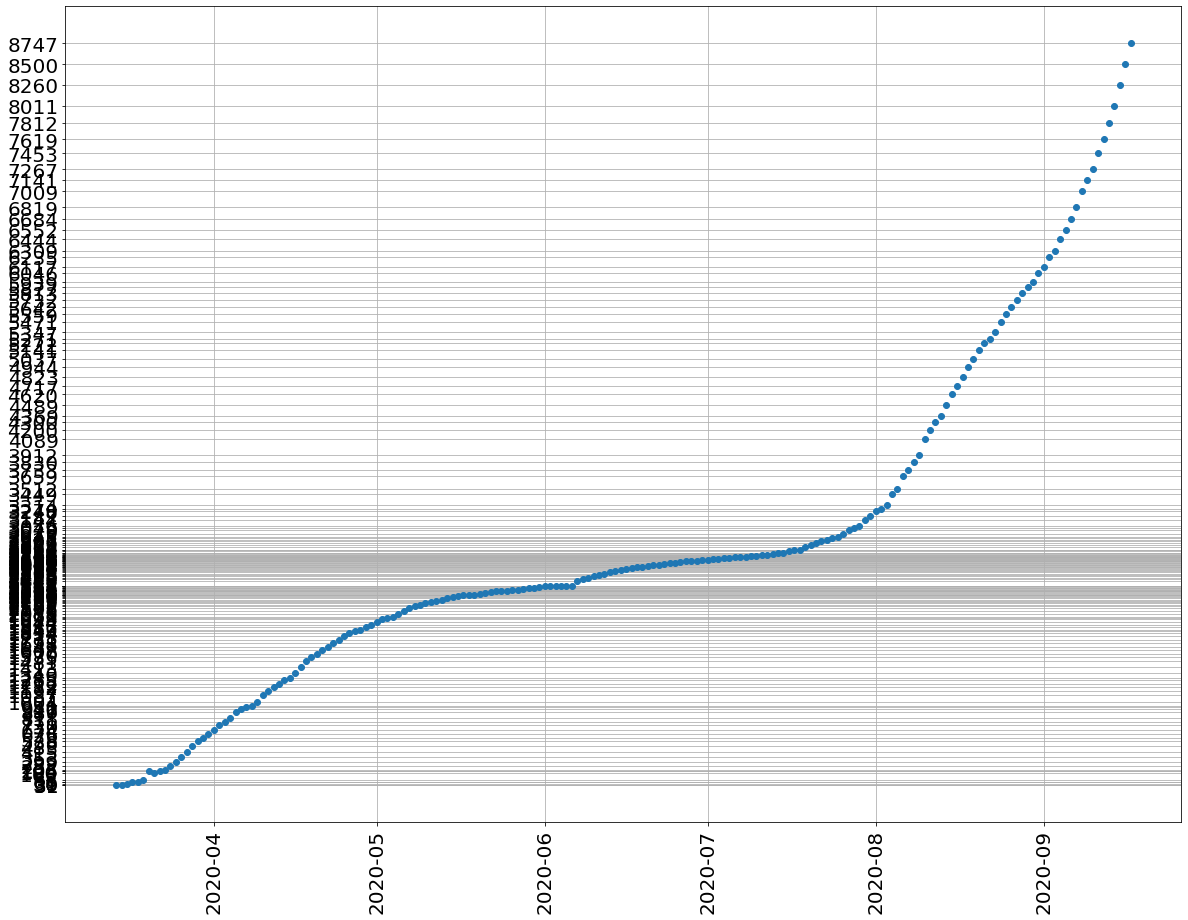

      Date_of_report  Total_reported
476       2020-03-14              31
843       2020-03-15              31
1210      2020-03-16              39
1577      2020-03-17              56
1944      2020-03-18              61
...              ...             ...
67637     2020-09-13            7812
68004     2020-09-14            8011
68371     2020-09-15            8260
68738     2020-09-16            8500
69105     2020-09-17            8747

[188 rows x 2 columns]


In [15]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Total_reported")

### Hospitalization daily delta for last 30 days

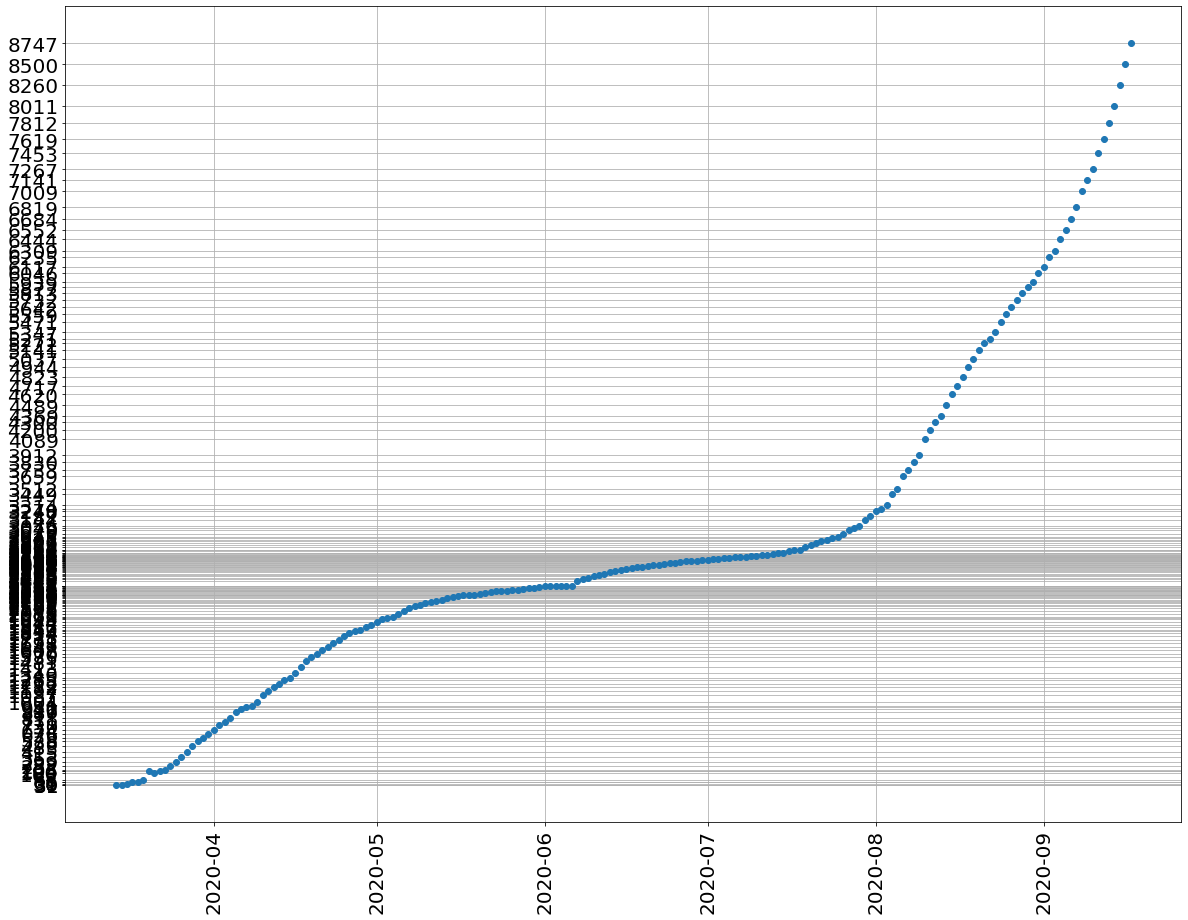

      Date_of_report  Total_reported
476       2020-03-14              31
843       2020-03-15              31
1210      2020-03-16              39
1577      2020-03-17              56
1944      2020-03-18              61
...              ...             ...
67637     2020-09-13            7812
68004     2020-09-14            8011
68371     2020-09-15            8260
68738     2020-09-16            8500
69105     2020-09-17            8747

[188 rows x 2 columns]


In [16]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Total_reported")

### Hospitalization daily delta for last 30 days

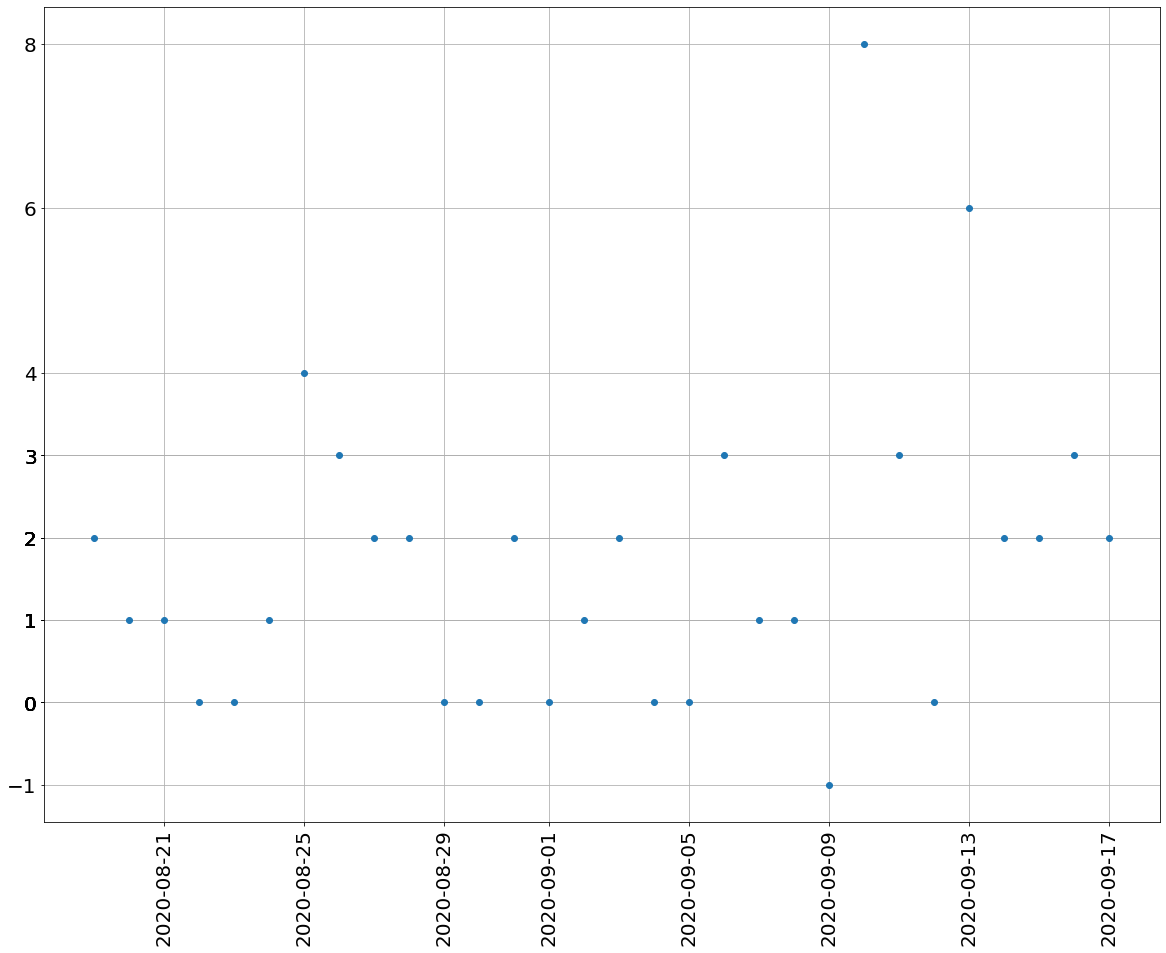

      Date_of_report  Hospital_delta
58462     2020-08-19               2
58829     2020-08-20               1
59196     2020-08-21               1
59563     2020-08-22               0
59930     2020-08-23               0
60297     2020-08-24               1
60664     2020-08-25               4
61031     2020-08-26               3
61398     2020-08-27               2
61765     2020-08-28               2
62132     2020-08-29               0
62499     2020-08-30               0
62866     2020-08-31               2
63233     2020-09-01               0
63600     2020-09-02               1
63967     2020-09-03               2
64334     2020-09-04               0
64701     2020-09-05               0
65068     2020-09-06               3
65435     2020-09-07               1
65802     2020-09-08               1
66169     2020-09-09              -1
66536     2020-09-10               8
66903     2020-09-11               3
67270     2020-09-12               0
67637     2020-09-13               6
6

In [17]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Hospital_delta")

### Cumulative hospitalizations for last 30 days

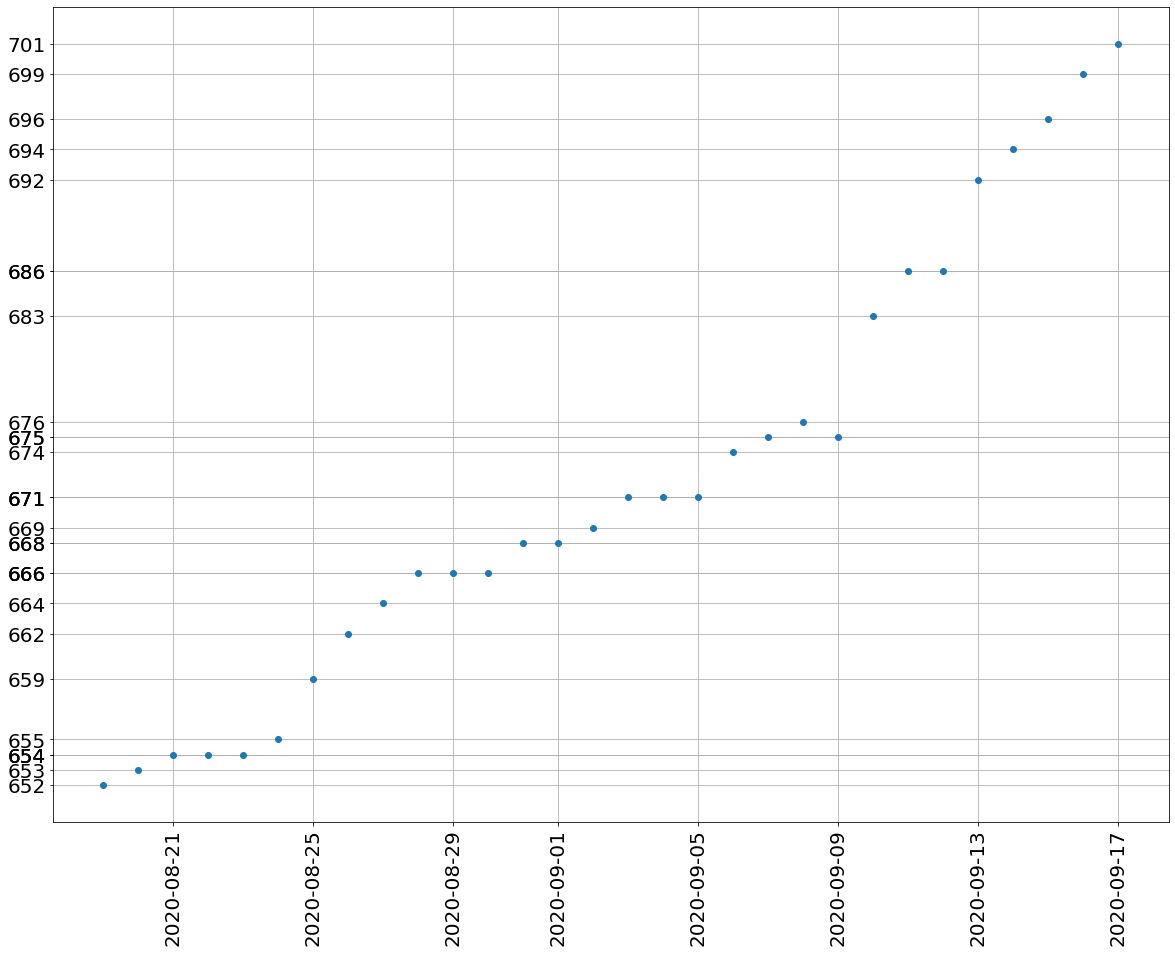

      Date_of_report  Hospital_admission
58462     2020-08-19                 652
58829     2020-08-20                 653
59196     2020-08-21                 654
59563     2020-08-22                 654
59930     2020-08-23                 654
60297     2020-08-24                 655
60664     2020-08-25                 659
61031     2020-08-26                 662
61398     2020-08-27                 664
61765     2020-08-28                 666
62132     2020-08-29                 666
62499     2020-08-30                 666
62866     2020-08-31                 668
63233     2020-09-01                 668
63600     2020-09-02                 669
63967     2020-09-03                 671
64334     2020-09-04                 671
64701     2020-09-05                 671
65068     2020-09-06                 674
65435     2020-09-07                 675
65802     2020-09-08                 676
66169     2020-09-09                 675
66536     2020-09-10                 683
66903     2020-0

In [18]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Hospital_admission")